In [1]:
## LIBRARIES
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import re

from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
## Input/Output
IMPORT_FOLDER =  "C:\\Users\\E2884\\Desktop\\WPy64-3980\\notebooks\\ENL_Script_analyse_magasin\\data\\"
FILE = "20231003_MB51.xlsx"
FILE2 = "20231003_ZMM_EDT_ART_02.xlsx"
FILE3 = "BDD_MATRICULES.xlsx"

In [3]:
## Import data from xls to pandas
df_MOUV = pd.read_excel(IMPORT_FOLDER + FILE, sheet_name='Sheet1')
df_BA = pd.read_excel(IMPORT_FOLDER + FILE2, sheet_name='Sheet1')
df_MATRICULES = pd.read_excel(IMPORT_FOLDER + FILE3, sheet_name='Feuil1')

In [4]:
## Rename and list columns
df_MOUV.rename(columns = {'Article':'CODE_ARTICLE',
                          'Désignation article':'DESIGNATION',
                          'Code mouvement':'CODE_MOUVEMENT',
                          'Texte code mouvement':'TEXTE_MOUVEMENT',
                          'Qté en unité saisie':'QTE_MVT',
                          'Montant DI':'VALEUR_MVT',
                          "Nom de l'utilisateur":'MATRICULE',
                          'Date de saisie':'DATE_MVT'}, inplace = True)
# for el in df_MOUV.columns.to_list():
#     print(el)

df_MOUV = df_MOUV[['CODE_ARTICLE','DESIGNATION','CODE_MOUVEMENT','TEXTE_MOUVEMENT','QTE_MVT','VALEUR_MVT','MATRICULE','DATE_MVT']]

In [5]:
## Rename and list columns
df_BA.rename(columns = {'N°Article':'CODE_ARTICLE',
                          'Désignation':'DESIGNATION',
                          'Emplacement':'EMPLACEMENT'}, inplace = True)
# for el in df_BA.columns.to_list():
#     print(el)

df_BA = df_BA[['CODE_ARTICLE','EMPLACEMENT']]

In [6]:
# Ajout macro emplacement à la base artcile
dict_EMPL_CONFORME = {"ADEFINIR":"NON_CONFORME",
                      "BACA":"BACA\d{4}",
                      "BACB":"BACB\d{4}",
                      "CHIMIE":"CHIMIE",
                      "CLIM":"CLIM(?:(\d{4}\S|SOL))",
                      "ENCOMMANDE":"ENCOMMANDE",
                      "FUEL":"FUEL",
                      "EXTDROIT":"EXTDROIT",
                      "EXTGAUCHE":"EXTGAUCHE",
                      "GP":"GP\S\d{4}\S",
                      "HUILERIE":"HUILERIE",
                      "LABO":"LABO",
                      "MT":"MT\S{4}",
                      "MTBAC" :"MTBAC\d{2}",
                      "MZ":"MZ\S\d{4}\S",
                      "PP":"PP\S\d{4}\S",
                      "PPBAC":"PP\S\d\SBAC",
                      "PPMUR":"PPMUR\d{2}",
                      "PPRECEPT":"PPRECEPT",
                      "PR":"PR\S\d{4}\S",
                     }

df_BA['EMPLACEMENT'] = df_BA['EMPLACEMENT'].fillna("VIDE")

list_EMPL_CONFORME = []
list_EMPL_NN_CONFORME = []
for emp in df_BA['EMPLACEMENT']:
    conformite = "NON_CONFORME"
    for key, value in dict_EMPL_CONFORME.items():
        tmp = re.findall(value, emp)
        if tmp != []:
            conformite = key
        else:
            pass
    list_EMPL_CONFORME.append(conformite)


df_BA['EMPLACEMENT_CONFORME']=list_EMPL_CONFORME

In [7]:
df_MOUV['DIGIT_MATRICULE'] = df_MOUV['MATRICULE'].astype(str).str[-4:]
df_MATRICULES['DIGIT_MATRICULE'] = df_MATRICULES['Matricule'].astype(str).str[-4:]

df_MOUV_tmp = pd.merge(df_MOUV,df_MATRICULES, on=['DIGIT_MATRICULE'])
df_MOUV_FIN = pd.merge(df_MOUV_tmp,df_BA, on=['CODE_ARTICLE'])
print(df_MOUV_FIN)

       CODE_ARTICLE                               DESIGNATION  CODE_MOUVEMENT  \
0        1000000015  MANOMETRE A MEMBRANE INJECTION PHOSPHATE             101   
1        1000000015  MANOMETRE A MEMBRANE INJECTION PHOSPHATE             261   
2        1000000015  MANOMETRE A MEMBRANE INJECTION PHOSPHATE             261   
3        1000000015  MANOMETRE A MEMBRANE INJECTION PHOSPHATE             261   
4        1000000016                MANOMETRE A MEMBRANE FIOUL             101   
...             ...                                       ...             ...   
67491    2208000051    ROULEMENT ROTULE ROULEAUX 23226CCK/W33             262   
67492    2208000053      ROULEMENT ROTULE ROULEAUX 22211EK/C3             262   
67493    2208000101             ROULEMENT CARB C 2211 KTN9/C3             262   
67494    2208000602          ROULEMENT RIGIDE A BILLE 6220 C3             262   
67495    2208010102                   MANCHON SERRAGE H 311 E             262   

           TEXTE_MOUVEMENT 

In [8]:
# Filtre sur l'exercice
DATE_DEBUT_EXERCICE = '2022-07-01'
df_MOUV_FIN_EX = df_MOUV_FIN[df_MOUV_FIN.DATE_MVT >= DATE_DEBUT_EXERCICE]


df_MOUV_FIN_EX = df_MOUV_FIN_EX[df_MOUV_FIN_EX.CODE_ARTICLE != 1000000099]

In [9]:
# gb type de mouvement
df_MOUV_FIN_EX_gb_MVT = df_MOUV_FIN_EX.groupby('TEXTE_MOUVEMENT').agg({'CODE_ARTICLE':'count','VALEUR_MVT':'sum'}).sort_values('CODE_ARTICLE',ascending=False)
print(df_MOUV_FIN_EX_gb_MVT)

                      CODE_ARTICLE  VALEUR_MVT
TEXTE_MOUVEMENT                               
Entrée en stock               1328   564383261
Sortie sur ordre               528  -111549301
Boni d'inventaire              448    51551312
Mali d'inventaire              243   -19992386
Réintégra° -> ordre             84    33067084
Annul. entrée stock             37   -23321411
TR Art. -> art.                 22           0
Réintégra° -> projet             3    14139213
AT Art.-> art.                   2           0
Mise au rebut                    1    -2050906
Sortie -> projet                 1      -20661


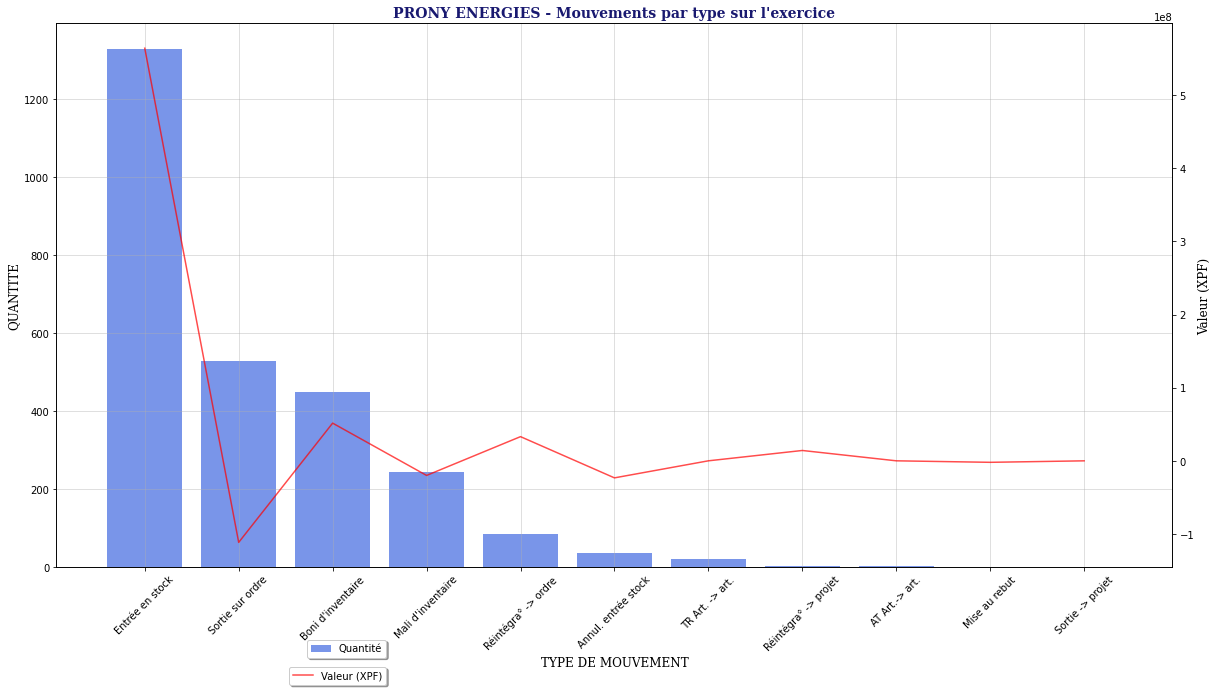

In [10]:
## GRAPHIQUE MATPLOTLIB
# Paramètres Titre
graph_title = "PRONY ENERGIES - Mouvements par type sur l'exercice"
title_family = 'serif'   # 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace'
title_color = 'midnightblue'
title_weight = 'bold'    # 'normal' | 'bold' | 'heavy' | 'light' | 'ultrabold' | 'ultralight'
title_size = 14
title_x = 0.5
title_y = 1

# Paramètres d'axes
x_label = "TYPE DE MOUVEMENT"
xtick_rotation = 45

y_label = "QUANTITE"
y2_label = "VALEUR (XPF)"

xy_label_family = 'serif'
xy_label_color = 'black'
xy_label_weight = 'light'
xy_label_size = 12

y1_color = 'royalblue'
y1_alpha = 0.7
y1_label = 'Quantité'

y2_color = 'red'
y2_alpha = 0.7
y2_label = 'Valeur (XPF)'

graph_linestyle = 'solid'

# # Paramètres texte instructions
# texte = "Ces données n'incluent pas le charbon \n\
# et les articles n'étant jamais sortis"

# text_x = -5
# text_y = 240
# text_family = 'serif'
# text_color = 'black'
# text_weight = 'light'
# text_size = 12
# bbox_facecolor = 'lemonchiffon'
# bbox_alpha = 0.5

# Paramètres grille
grid_alpha = 0.5

###########################################################################################################
fig, axe1 = plt.subplots(nrows=1, ncols=1, figsize=(20,10), sharex=True)
fig.subplots_adjust(hspace=0)

plt.xticks(rotation=xtick_rotation)

# Axe n°1
axe1.set_title(graph_title, x=title_x, y=title_y,fontdict={'family': title_family,'color' : title_color,'weight': title_weight,'size': title_size})
axe1.set_xlabel(x_label, fontdict={'family': xy_label_family,'color' : xy_label_color,'weight': xy_label_weight,'size': xy_label_size})
axe1.set_ylabel(y_label, fontdict={'family': xy_label_family,'color' : xy_label_color,'weight': xy_label_weight,'size': xy_label_size})

axe1.bar(df_MOUV_FIN_EX_gb_MVT.index.values, df_MOUV_FIN_EX_gb_MVT.CODE_ARTICLE, color=y1_color, alpha = y1_alpha, label=y1_label)

axe1.legend(loc="center right",bbox_to_anchor=(0.3, -0.15), ncol=1, fancybox=True, shadow=True)
axe1.grid(True, alpha=grid_alpha)

#Axe n°2
axe2 = axe1.twinx()
axe2.set_ylabel(y2_label, fontdict={'family': xy_label_family,'color' : xy_label_color,'weight': xy_label_weight,'size': xy_label_size})

axe2.plot(df_MOUV_FIN_EX_gb_MVT.index.values, df_MOUV_FIN_EX_gb_MVT.VALEUR_MVT, color = y2_color, linestyle=graph_linestyle, alpha = y2_alpha, label=y2_label)

axe2.legend(loc="center right",bbox_to_anchor=(0.3, -0.20), ncol=1, fancybox=True, shadow=True)
# axe2.set_ylim(0,101)

In [11]:
# gb type de mouvement
df_MOUV_FIN_EX_gb_EMPL = df_MOUV_FIN_EX.groupby('EMPLACEMENT_CONFORME').agg({'CODE_ARTICLE':'count','VALEUR_MVT':'sum'}).sort_values('CODE_ARTICLE',ascending=False)
print(df_MOUV_FIN_EX_gb_EMPL)

                      CODE_ARTICLE  VALEUR_MVT
EMPLACEMENT_CONFORME                          
MZ                             738    84062983
PP                             561    67764380
CHIMIE                         441     5992611
PR                             330    54777713
GP                             267   152800579
NON_CONFORME                    65    62126294
BACA                            59     1079168
FUEL                            57      297585
ENCOMMANDE                      55    11008587
BACB                            54     1247502
EXTDROIT                        27    55488892
HUILERIE                        22    11135171
PPMUR                            7       -2352
EXTGAUCHE                        4    -3117795
LABO                             3       30300
MT                               3     1765280
PPBAC                            2      -90375
MTBAC                            1       18678
CLIM                             1     -178996


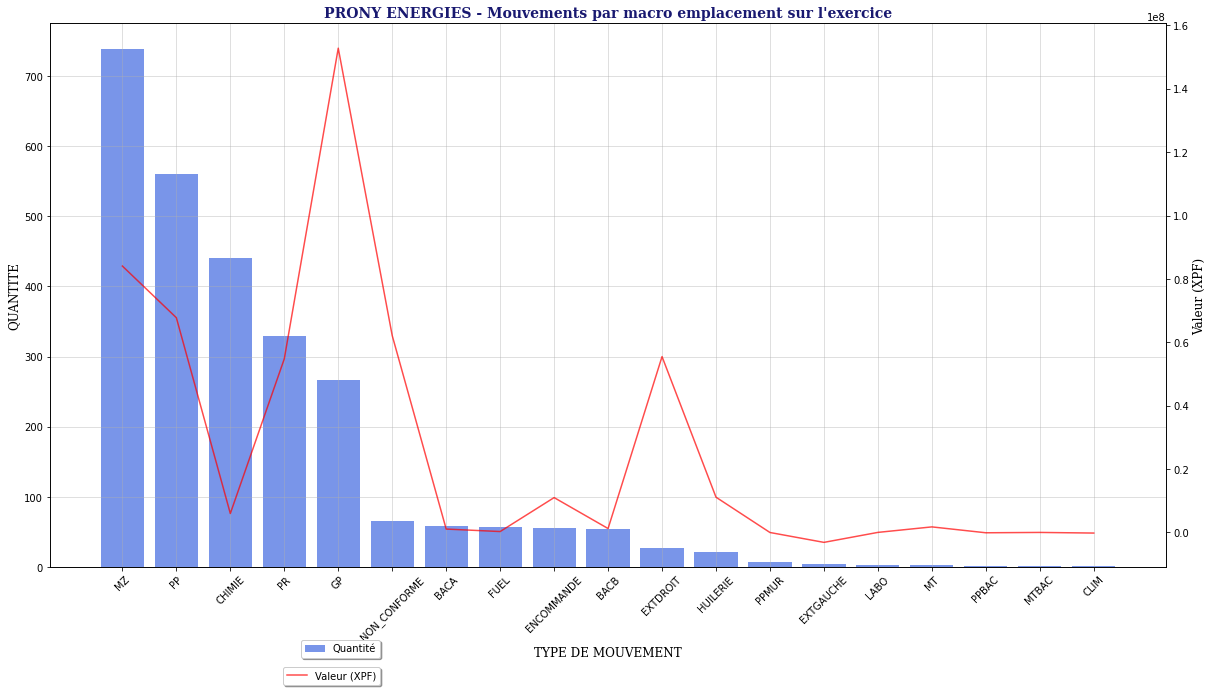

In [12]:
## GRAPHIQUE MATPLOTLIB
# Paramètres Titre
graph_title = "PRONY ENERGIES - Mouvements par macro emplacement sur l'exercice"
title_family = 'serif'   # 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace'
title_color = 'midnightblue'
title_weight = 'bold'    # 'normal' | 'bold' | 'heavy' | 'light' | 'ultrabold' | 'ultralight'
title_size = 14
title_x = 0.5
title_y = 1

# Paramètres d'axes
x_label = "TYPE DE MOUVEMENT"
xtick_rotation = 45

y_label = "QUANTITE"
y2_label = "VALEUR (XPF)"

xy_label_family = 'serif'
xy_label_color = 'black'
xy_label_weight = 'light'
xy_label_size = 12

y1_color = 'royalblue'
y1_alpha = 0.7
y1_label = 'Quantité'

y2_color = 'red'
y2_alpha = 0.7
y2_label = 'Valeur (XPF)'

graph_linestyle = 'solid'

# # Paramètres texte instructions
# texte = "Ces données n'incluent pas le charbon \n\
# et les articles n'étant jamais sortis"

# text_x = -5
# text_y = 240
# text_family = 'serif'
# text_color = 'black'
# text_weight = 'light'
# text_size = 12
# bbox_facecolor = 'lemonchiffon'
# bbox_alpha = 0.5

# Paramètres grille
grid_alpha = 0.5

###########################################################################################################
fig, axe1 = plt.subplots(nrows=1, ncols=1, figsize=(20,10), sharex=True)
fig.subplots_adjust(hspace=0)

plt.xticks(rotation=xtick_rotation)

# Axe n°1
axe1.set_title(graph_title, x=title_x, y=title_y,fontdict={'family': title_family,'color' : title_color,'weight': title_weight,'size': title_size})
axe1.set_xlabel(x_label, fontdict={'family': xy_label_family,'color' : xy_label_color,'weight': xy_label_weight,'size': xy_label_size})
axe1.set_ylabel(y_label, fontdict={'family': xy_label_family,'color' : xy_label_color,'weight': xy_label_weight,'size': xy_label_size})

axe1.bar(df_MOUV_FIN_EX_gb_EMPL.index.values, df_MOUV_FIN_EX_gb_EMPL.CODE_ARTICLE, color=y1_color, alpha = y1_alpha, label=y1_label)

axe1.legend(loc="center right",bbox_to_anchor=(0.3, -0.15), ncol=1, fancybox=True, shadow=True)
axe1.grid(True, alpha=grid_alpha)

#Axe n°2
axe2 = axe1.twinx()
axe2.set_ylabel(y2_label, fontdict={'family': xy_label_family,'color' : xy_label_color,'weight': xy_label_weight,'size': xy_label_size})

axe2.plot(df_MOUV_FIN_EX_gb_EMPL.index.values, df_MOUV_FIN_EX_gb_EMPL.VALEUR_MVT, color = y2_color, linestyle=graph_linestyle, alpha = y2_alpha, label=y2_label)

axe2.legend(loc="center right",bbox_to_anchor=(0.3, -0.20), ncol=1, fancybox=True, shadow=True)
# axe2.set_ylim(0,101)

In [13]:
# gb matricule
df_MOUV_FIN_EX_gb_agent = df_MOUV_FIN_EX.groupby('Agent').agg({'CODE_ARTICLE':'count','VALEUR_MVT':'sum'}).sort_values('CODE_ARTICLE',ascending=False)
print(df_MOUV_FIN_EX_gb_agent)

               CODE_ARTICLE  VALEUR_MVT
Agent                                  
A. TELLIEZ              756    35008966
K. Sakoumory            679   105780187
J. Rota                 495    77221546
N. Wendt                303   168282078
M. ATUFELE              279    93222667
L. Lutikova              87    25728818
G. PUJAPUJANE            42    -2607984
S. Clerc                 40    -6145924
T. MULILOTO               9      314153
N. Vincent                3     5004055
E. Sioremu                1     1647643
E2312                     1      520000
F. Mayissian              1     1710000
G. DEPREZ                 1      520000


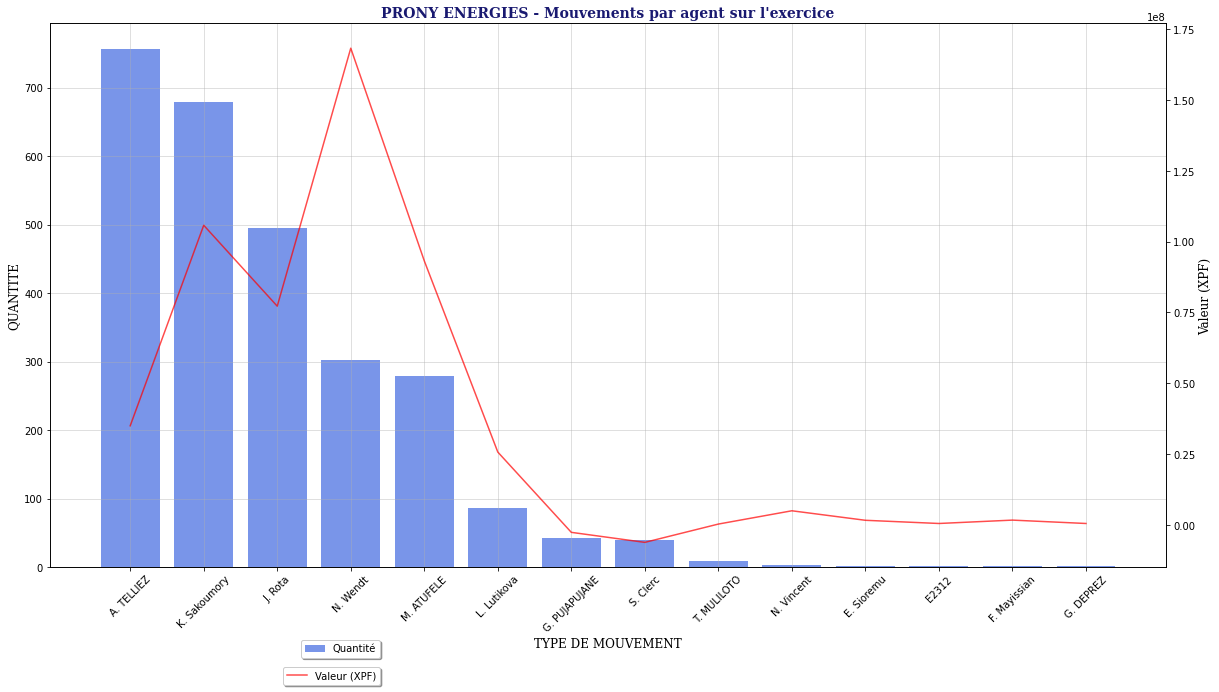

In [14]:
## GRAPHIQUE MATPLOTLIB
# Paramètres Titre
graph_title = "PRONY ENERGIES - Mouvements par agent sur l'exercice"
title_family = 'serif'   # 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace'
title_color = 'midnightblue'
title_weight = 'bold'    # 'normal' | 'bold' | 'heavy' | 'light' | 'ultrabold' | 'ultralight'
title_size = 14
title_x = 0.5
title_y = 1

# Paramètres d'axes
x_label = "TYPE DE MOUVEMENT"
xtick_rotation = 45

y_label = "QUANTITE"
y2_label = "VALEUR (XPF)"

xy_label_family = 'serif'
xy_label_color = 'black'
xy_label_weight = 'light'
xy_label_size = 12

y1_color = 'royalblue'
y1_alpha = 0.7
y1_label = 'Quantité'

y2_color = 'red'
y2_alpha = 0.7
y2_label = 'Valeur (XPF)'

graph_linestyle = 'solid'

# # Paramètres texte instructions
# texte = "Ces données n'incluent pas le charbon \n\
# et les articles n'étant jamais sortis"

# text_x = -5
# text_y = 240
# text_family = 'serif'
# text_color = 'black'
# text_weight = 'light'
# text_size = 12
# bbox_facecolor = 'lemonchiffon'
# bbox_alpha = 0.5

# Paramètres grille
grid_alpha = 0.5

###########################################################################################################
fig, axe1 = plt.subplots(nrows=1, ncols=1, figsize=(20,10), sharex=True)
fig.subplots_adjust(hspace=0)

plt.xticks(rotation=xtick_rotation)

# Axe n°1
axe1.set_title(graph_title, x=title_x, y=title_y,fontdict={'family': title_family,'color' : title_color,'weight': title_weight,'size': title_size})
axe1.set_xlabel(x_label, fontdict={'family': xy_label_family,'color' : xy_label_color,'weight': xy_label_weight,'size': xy_label_size})
axe1.set_ylabel(y_label, fontdict={'family': xy_label_family,'color' : xy_label_color,'weight': xy_label_weight,'size': xy_label_size})

axe1.bar(df_MOUV_FIN_EX_gb_agent.index.values, df_MOUV_FIN_EX_gb_agent.CODE_ARTICLE, color=y1_color, alpha = y1_alpha, label=y1_label)

axe1.legend(loc="center right",bbox_to_anchor=(0.3, -0.15), ncol=1, fancybox=True, shadow=True)
axe1.grid(True, alpha=grid_alpha)

#Axe n°2
axe2 = axe1.twinx()
axe2.set_ylabel(y2_label, fontdict={'family': xy_label_family,'color' : xy_label_color,'weight': xy_label_weight,'size': xy_label_size})

axe2.plot(df_MOUV_FIN_EX_gb_agent.index.values, df_MOUV_FIN_EX_gb_agent.VALEUR_MVT, color = y2_color, linestyle=graph_linestyle, alpha = y2_alpha, label=y2_label)

axe2.legend(loc="center right",bbox_to_anchor=(0.3, -0.20), ncol=1, fancybox=True, shadow=True)
# axe2.set_ylim(0,101)

In [15]:
df_MOUV_FIN_EX_gb_caq = df_MOUV_FIN_EX.groupby(['DESIGNATION','EMPLACEMENT_CONFORME']).agg({'CODE_ARTICLE':'count','VALEUR_MVT':'sum'}).sort_values('CODE_ARTICLE',ascending=False)
print(df_MOUV_FIN_EX_gb_caq.head(20))

                                                           CODE_ARTICLE  \
DESIGNATION                          EMPLACEMENT_CONFORME                 
GASOIL                               FUEL                            57   
NALCO 3DT404 KG                      CHIMIE                          45   
NALCO 3DT129 KG                      CHIMIE                          42   
NALCO 77352 KG                       CHIMIE                          41   
NALCO CONTROLBROM CB40 KG            CHIMIE                          40   
ACIDE SULFURIQUE 60%                 CHIMIE                          40   
NALCO 73550 KG                       CHIMIE                          37   
NALCO 5711 KG                        CHIMIE                          34   
SOLUTION HYDROXIDE DE SODIUM 50%     CHIMIE                          33   
HTH BRIQUETTE CHLORE 7G AU KG        CHIMIE                          26   
NALCO 72215                          CHIMIE                          26   
ACIDE CHLORHYDRIQUE 32/33

In [16]:
df_MOUV_FIN_EX_gb_cav = df_MOUV_FIN_EX.groupby(['DESIGNATION','EMPLACEMENT_CONFORME']).agg({'CODE_ARTICLE':'count','VALEUR_MVT':'sum'}).sort_values('VALEUR_MVT',ascending=False)
print(df_MOUV_FIN_EX_gb_cav.head(20))

                                                               CODE_ARTICLE  \
DESIGNATION                              EMPLACEMENT_CONFORME                 
BARREL HP RECONDITIONNE                  NON_CONFORME                     1   
PLATEN SUPERHEATER ELEMENT               NON_CONFORME                     1   
ENSEMBLE DE 72 PANIERS CHAUDS            EXTDROIT                         4   
BUS COUPLER WSB                          EXTDROIT                         1   
HUILE SHELL TURBO S4GX46 - AU LITRE      HUILERIE                         8   
ENSEMBLE SOUPAPES REGULATRICES Ø250      NON_CONFORME                     1   
COUSSINET HP COTE ADMISSION - 13020O     GP                               2   
REDUCTEUR BROYEUR COMPLET RECONDITIONNE  EXTDROIT                         1   
PATIN BUTEE ET CONTRE BUTEE HP 13060O    GP                               2   
CERCLE DE VANNAGE COMPLET                EXTDROIT                         6   
MOTEUR MPA POMPE ALIMENTAIRE 570kW       GP         